In [1]:
import sys
sys.path.append('/home/brain3/Desktop/Pose-Estimation-for-Sensor-Calibration')

import cv2
import numpy as np
import os
import glob
# import pickle

# import rospy
from ur_msgs.srv import JointTrajectory, EndPose, JointStates

from matplotlib import pyplot as plt
from utils_realsense import RealSenseSensor

from realrobot_utils import *

# from calibration_helper import *
# from custom_geometric_transform import *
# from transformations import quaternion_matrix
# from transformations import quaternion_from_matrix
# from transformations import rotation_matrix

# from helpers import Tools
# EPS=0.00001
from Pose_Estimation_Class import *

In [2]:
realsense = RealSenseSensor("025222072234")
K_rs = realsense._color_intrinsics
D_rs = 0

In [3]:
planUR5 = rospy.ServiceProxy('plan_robot_arm', JointTrajectory)
moveUR5 = rospy.ServiceProxy('move_robot_arm', JointTrajectory)
getEEFPose = rospy.ServiceProxy('get_eef_pose', EndPose)
getJointStates = rospy.ServiceProxy('get_joint_states', JointStates)

In [4]:
rospy.wait_for_service('plan_robot_arm')
rospy.wait_for_service('move_robot_arm')
rospy.wait_for_service('get_eef_pose')
rospy.wait_for_service('get_joint_states')

In [5]:
ROBOT_INIT_POS = [0.0, -0.3, 0.65]

In [6]:
def get_joint_states():
    joints_Str = getJointStates().joint_states.replace('(', '').replace(')', '').split(', ')
    joints = [float(j) for j in joints_Str]
    return joints

In [7]:
def get_eef_pose():
    pose = getEEFPose().eef_pose
    position = [pose.position.x, pose.position.y, pose.position.z]
    quaternion = [pose.orientation.x, pose.orientation.y, pose.orientation.z, pose.orientation.w]
    return position, quaternion

In [8]:
def get_view(goal_pos=None, quat=[-1, 0, 0, 0]):
    ARM_JOINT_NAME = ['shoulder_pan_joint', 'shoulder_lift_joint', 'elbow_joint', 'wrist_1_joint', 'wrist_2_joint', 'wrist_3_joint']
    if goal_pos is not None:
        plans = moveUR5(ARM_JOINT_NAME, None, goal_pos, quat)
    color, depth = realsense.frames(spatial=True, hole_filling=True, temporal=True)
    plt.imshow(color)
    return color, depth

In [9]:
CHECKERBOARD = (6, 9)
def get_cam_theta_p(color):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    plt.imshow(img)
    plt.show()
    return R_vec_cam_to_chess, p_cam_to_chess

def get_cam_R_T(color):
    objpoints_rs, corners_rs = get_chessboard_corners(color)
    img = cv2.drawChessboardCorners(np.array(color), CHECKERBOARD, corners_rs, True)
    plt.imshow(img)
    plt.show()
    err_value, R_vec_cam_to_chess, p_cam_to_chess = cv2.solvePnP(objpoints_rs, corners_rs, K_rs, D_rs)
    R_cam_to_chess, _ = cv2.Rodrigues(R_vec_cam_to_chess)
    T_cam_to_chess = form_T(R_cam_to_chess, p_cam_to_chess)
    return R_cam_to_chess, T_cam_to_chess

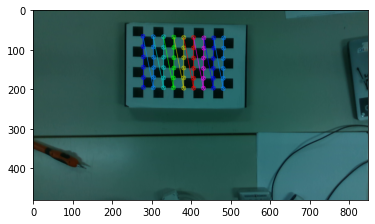

(array([[ 0.01002214,  0.99851024, -0.05363634],
        [-0.99736974,  0.00613119, -0.07222199],
        [-0.07178555,  0.05421908,  0.99594534]]),
 array([[ 0.01002214,  0.99851024, -0.05363634, -0.04164679],
        [-0.99736974,  0.00613119, -0.07222199, -0.11633511],
        [-0.07178555,  0.05421908,  0.99594534,  0.59886535],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [10]:
img, _ = get_view(ROBOT_INIT_POS)
get_cam_R_T(img)

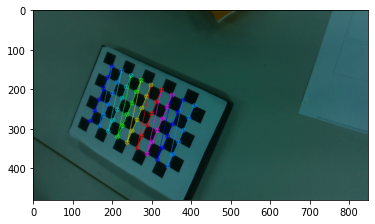

[-0.249, -0.528, 0.45]
[0.9646, 0.2047, 0.1661, -0.0022]


In [18]:
img, _ = get_view(None)
get_cam_R_T(img)
pos, quat = get_eef_pose()
print([np.round(p, 3) for p in pos])
print([np.round(q, 4) for q in quat])

In [11]:
calib_positions = np.array([
    [0.0, -0.3, 0.65],
    [0.282, -0.413, 0.606],
    [0.249, -0.217, 0.567],
    [-0.193, -0.278, 0.495],
    [-0.249, -0.528, 0.45]
])
calib_quaternions = np.array([
    [1.0, 0.0, 0.0, 0.0],
    [0.9634, 0.2052, -0.1588, -0.067],
    [0.9626, 0.1529, -0.205, 0.09],
    [0.9697, -0.1399, 0.191, 0.0606],
    [0.9646, 0.2047, 0.1661, -0.0022]
])

calib_positions = np.array([
        [0.0, -0.3, 0.65],
        [0.0, -0.49, 0.59],
        [0.25, -0.41, 0.61],
        [0.26, -0.19, 0.61],
        [-0.09, -0.39, 0.58]
    ])
calib_quaternions = np.array([
        [1.0, 0.0, 0.0, 0.0],
        [0.990, 0.004, 0.004, -0.139],
        [0.994, 0.005, -0.112, -0.014],
        [0.976, 0.028, -0.109, 0.187],
        [0.994, 0.068, 0.083, 0.002]
    ])

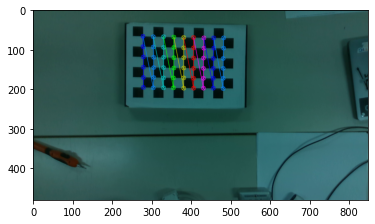

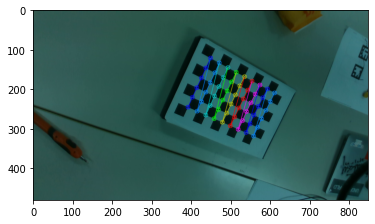

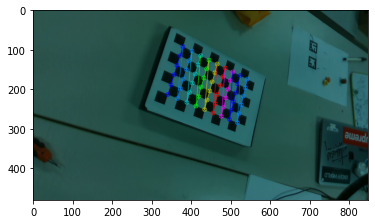

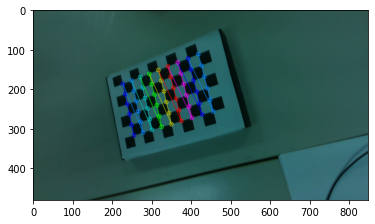

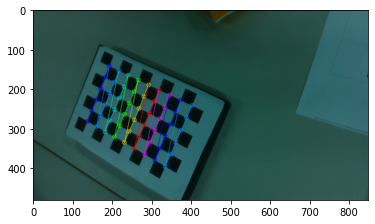

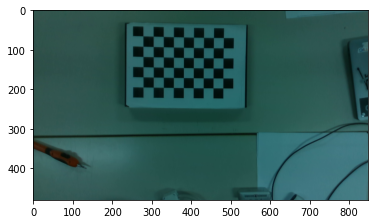

In [12]:
T_realsense = []
T_ur5 = []
for p, q in zip(calib_positions, calib_quaternions):
    img, _ = get_view(p, q)
    R, T_cam_to_chess = get_cam_R_T(img)
    
    T_base_to_eef = form_T(quaternion_matrix(q)[:3, :3], p)
    
    T_realsense.append(T_cam_to_chess)
    T_ur5.append(T_base_to_eef)

img, _ = get_view(ROBOT_INIT_POS)

In [13]:
# form A, B matrix
A = []
B = []
T_pre = T_realsense[0]
for T in T_realsense[1:]:
    A.append(T.dot(np.linalg.inv(T_pre)))
    T_pre = T

T_pre = T_ur5[0]
for T in T_ur5[1:]:
    B.append(T.dot(np.linalg.inv(T_pre)))
    T_pre = T

A = np.array(A)
B = np.array(B)

+ Simultaneous Robot/World and Tool/Flange Calibration:    
Implementation of Shah, Mili. "Solving the robot-world/hand-eye calibration problem using the Kronecker product." 
Journal of Mechanisms and Robotics 5.3 (2013): 031007.

Batch_Processing solvesfor  X and Y in AX=YB from a set of (A,B) paired measurements.
(Ai,Bi) are absolute pose measurements with known correspondance       
A: (4x4xn) 
X: (4x4): unknown
Y: (4x4): unknown
B: (4x4xn) 
n number of measurements

+ EKF,IEKF solves for AX=XB from a set of (Ai,Bi) relative pose measurements with known correspondance.
so3 representation was used to represent the state of rotation.  

In [14]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_rs_to_eef)
# iekf_euler_err=np.array(euler_iekf)*180/np.pi-np.array(euler_GT)*180/np.pi
# iekf_pos_err=iekf.x[3:].T*100-X[:3,3].T*100
# print("IEKF [euler_rpy(deg) , pos(mm)]:",np.array([euler_iekf])*180/np.pi,iekf.x[3:]*100)
# print("Error[euler_rpy(deg) , pos(mm)]:", iekf_euler_err, iekf_pos_err)

IEKF Results
Euler: [-3.63473632 15.93183479 -2.5802966 ]
Translation: [0.01455519 0.01606758 0.05018786]
------------------------------
[[ 0.95965469  0.06096048  0.27449354  0.01455519]
 [-0.07566399  0.99619321  0.04329021  0.01606758]
 [-0.27080961 -0.06231293  0.960614    0.05018786]
 [ 0.          0.          0.          1.        ]]


In [15]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_rs_to_eef)
# iekf_euler_err=np.array(euler_iekf)*180/np.pi-np.array(euler_GT)*180/np.pi
# iekf_pos_err=iekf.x[3:].T*100-X[:3,3].T*100
# print("IEKF [euler_rpy(deg) , pos(mm)]:",np.array([euler_iekf])*180/np.pi,iekf.x[3:]*100)
# print("Error[euler_rpy(deg) , pos(mm)]:", iekf_euler_err, iekf_pos_err)

IEKF Results
Euler: [-3.63473632 15.93183479 -2.5802966 ]
Translation: [0.01455519 0.01606758 0.05018786]
------------------------------
[[ 0.95965469  0.06096048  0.27449354  0.01455519]
 [-0.07566399  0.99619321  0.04329021  0.01606758]
 [-0.27080961 -0.06231293  0.960614    0.05018786]
 [ 0.          0.          0.          1.        ]]


In [61]:
#UKF
ukf = UKF()
for i in range(len(A[1,1,:])):
    AA = A[:,:,i] 
    BB = B[:,:,i]
    ukf.Update(AA,BB)
    
theta = np.linalg.norm(ukf.x[:3])
if theta < EPS:
    k = [0,1,0] #VRML standard
else:
    k = ukf.x[0:3]/np.linalg.norm(ukf.x[:3])
euler_ukf = Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('UKF Results')
print('Euler:', np.array(euler_ukf)*180/np.pi)
print('Translation:', ukf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), ukf.x[3:])
print(T_rs_to_eef)


ukf_euler_err=np.array(euler_ukf)*180/np.pi-np.array(euler_GT)*180/np.pi
ukf_pos_err=ukf.x[3:].T*100-X[:3,3].T*100
print("UKF [euler_rpy(deg) , pos(mm)]:",np.array([euler_ukf])*180/np.pi,ukf.x[3:]*100)
print("Error[euler_rpy(deg) , pos(mm)]:", ukf_euler_err, ukf_pos_err)

NameError: name 'BB' is not defined

In [17]:
#IEKF
iekf=IEKF()
for i in range(len(A[1,1,:])):
    AA=A[:,:,i] 
    BB=B[:,:,i]
    iekf.Update(AA,BB)
    
theta=np.linalg.norm(iekf.x[:3])
if theta < EPS:
    k=[0,1,0] #VRML standard
else:
    k=iekf.x[0:3]/np.linalg.norm(iekf.x[:3])
euler_iekf=Tools.mat2euler(Tools.vec2rotmat(theta, k))

print('IEKF Results')

# print(euler_iekf)
print('Euler:', np.array(euler_iekf)*180/np.pi)
print('Translation:', iekf.x[3:])
print('------------------------------')
T_rs_to_eef = form_T(Tools.vec2rotmat(theta, k), iekf.x[3:])
print(T_rs_to_eef)
# iekf_euler_err=np.array(euler_iekf)*180/np.pi-np.array(euler_GT)*180/np.pi
# iekf_pos_err=iekf.x[3:].T*100-X[:3,3].T*100
# print("IEKF [euler_rpy(deg) , pos(mm)]:",np.array([euler_iekf])*180/np.pi,iekf.x[3:]*100)
# print("Error[euler_rpy(deg) , pos(mm)]:", iekf_euler_err, iekf_pos_err)

IEKF Results
Euler: [-4.14308188 14.00678143  5.42469274]
Translation: [-0.0408612   0.03313901  0.02592064]
------------------------------
[[ 0.96773153  0.07009929  0.24203674 -0.0408612 ]
 [-0.04910213  0.99457289 -0.09172649  0.03313901]
 [-0.24715314  0.0768821   0.96592156  0.02592064]
 [ 0.          0.          0.          1.        ]]


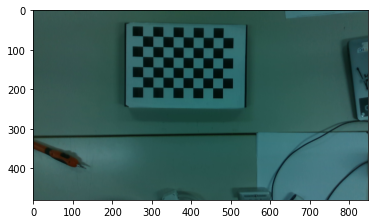

In [50]:
color, depth = get_view(ROBOT_INIT_POS)

In [52]:
goal_pixel = np.array([420, 240])
p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
print(p_rs_to_goal)

[-0.00302957 -0.01081482  0.61500001]


In [57]:
def move_to_pixel(color, goal_pixel):
    color[goal_pixel[1], goal_pixel[0]] = [255,0,0]
    plt.imshow(color)
    plt.show()

    p_rs_to_goal = inverse_projection(depth, goal_pixel, K_rs, D_rs)
    print(p_rs_to_goal)
    
    T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)
    T_eef_to_rs = np.linalg.inv(T_rs_to_eef)
    # T_eef_to_rs = np.linalg.inv(form_T(np.eye(3), T_rs_to_eef[:3, 3]))
    T_rs_to_goal = np.linalg.inv(form_T(np.eye(3), p_rs_to_goal))

    T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))
    # T_base_to_goal = T_base_to_initeef.dot(T_rs_to_goal)
    
    
    goal_position = T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])
    print(goal_position)
    _ = get_view(goal_position)

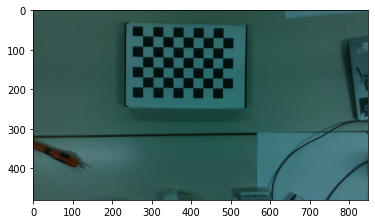

[-0.19337451  0.17914801  0.64000005]
[ 0.37155244 -0.43974374  0.22720742]


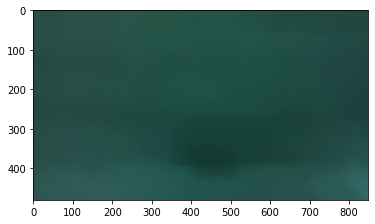

In [60]:
goal_pixel = np.array([240, 420])
move_to_pixel(color, goal_pixel)

In [54]:
color.shape

(480, 848, 3)

In [48]:
T_base_to_initeef = form_T(np.eye(3), ROBOT_INIT_POS)
T_eef_to_rs = np.linalg.inv(T_rs_to_eef)
# T_eef_to_rs = np.linalg.inv(form_T(np.eye(3), T_rs_to_eef[:3, 3]))
T_rs_to_goal = np.linalg.inv(form_T(np.eye(3), p_rs_to_goal))

T_base_to_goal = T_base_to_initeef.dot(T_eef_to_rs.dot(T_rs_to_goal))
# T_base_to_goal = T_base_to_initeef.dot(T_rs_to_goal)

In [49]:
T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])

array([ 15.68720214,   4.85535939, -62.65894225])

In [34]:
T_base_to_goal[:3, 3] + np.array([0, 0, 0.2])

array([-0.01722437, -0.28922035,  0.23699996])

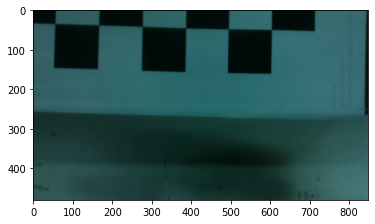

In [41]:
_ = get_view(T_base_to_goal[:3, 3] + np.array([0, 0, 0.2]))

In [ ]:
def move_to_pixel(center_x, center_y):
    pixel = np.array([center_x, center_y], np.int32)
    grasp_depth = 0.70
    psi = 0.0
    midx, midy = realsense._intrinsics[:2,2]
    raw_pixel = inverse_raw_pixel(pixel, midx, midy, cs=430)
    
    endpoint_pose_base = baxter_right_arm._limb.endpoint_pose()
    T_base_to_endpoint = get_transformation_from_pose(endpoint_pose_base)
    T_endpoint_to_realsense = np.linalg.inv(T_realsense_to_endpoint)
    
    K_realsense, D_realsense = realsense.get_realsense_camera_K_and_D()
    bin_input_rgb_im, bin_input_depth_im, _, _, bin_depth_im, _= get_input_rgbd_image(realsense, crop_size = 430, resize_width = 256, resize_height = 256)
    
    diff_endpoint_position_realsense = inverse_projection(bin_depth_im, raw_pixel, K_realsense, D_realsense)
    diff_endpoint_position_realsense[2] = grasp_depth
    diff_endpoint_quaternion_realsense = quaternion_from_matrix(T_realsense_to_endpoint.dot(rotation_matrix(psi, [0.,0.,1.])))
    
    T_realsense_to_new_endpoint = form_T(quaternion_matrix(diff_endpoint_quaternion_realsense)[:3,:3], diff_endpoint_position_realsense)
    T_base_to_new_endpoint =T_base_to_endpoint.dot(T_endpoint_to_realsense.dot(T_realsense_to_new_endpoint))
    goal_eef_position = T_base_to_new_endpoint[:3,3]
    goal_eef_quaternion = quaternion_from_matrix(T_base_to_new_endpoint)
    goal_eef_jointangles = baxter_right_arm.move_to_pose(goal_eef_position+[0.0, 0.0, 0.05], goal_eef_quaternion, timeout=10.0)
    goal_eef_jointangles = baxter_right_arm.move_to_pose(goal_eef_position, goal_eef_quaternion, timeout=10.0)
    
    return goal_eef_position